In [2072]:
from glob import glob
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from mido import MidiFile
from tqdm import tqdm
from shutil import copyfile
import pickle

# labels = glob("./data/rousseau/labels/testing/*")
# labels = sorted(labels, key=lambda x: int(x.split("/")[-1].split("_")[0]))

In [2078]:
images = glob("./data/rousseau/images/testing/*")
images = sorted(images, key=lambda x: int(x.split("/")[-1].split("_")[0]))

In [2079]:
def intkey_to_str(arr):
    notes = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
    notes_str = []
    for key_int in arr:
        note = notes[key_int%12]
        octave = (key_int+9) // 12 + 1
        notes_str.append(note + str(octave))
    return notes_str

In [2080]:
def show_5_images(image_idx_mid):
    assert image_idx_mid >= 1
    plt.figure(figsize=(20, 15))
    plt.axis("off")
    plt.subplot(5, 1, 1)
    plt.title(img_list[image_idx_mid-3])
    plt.imshow(Image.open(os.path.join(images[idx], img_list[image_idx_mid-3])))
    plt.subplot(5, 1, 2)
    plt.title(img_list[image_idx_mid-2])
    plt.imshow(Image.open(os.path.join(images[idx], img_list[image_idx_mid-2])))
    plt.subplot(5, 1, 3)
    plt.title(img_list[image_idx_mid-1])
    plt.imshow(Image.open(os.path.join(images[idx], img_list[image_idx_mid-1]))) # mid
    plt.subplot(5, 1, 4)
    plt.title(img_list[image_idx_mid])
    plt.imshow(Image.open(os.path.join(images[idx], img_list[image_idx_mid])))
    plt.subplot(5, 1, 5)
    plt.title(img_list[image_idx_mid+1])
    plt.imshow(Image.open(os.path.join(images[idx], img_list[image_idx_mid+1])))

In [2606]:
# start from here

idx = 18
print(images[idx])
# print(labels[idx])

data_id = images[idx].split("/")[-1].split("_")[0]
img_list = sorted(os.listdir(images[idx]), key=lambda x: int(x.split(".")[0]))

IndexError: list index out of range

In [2575]:
# label = np.load(labels[idx], allow_pickle=True)

In [2576]:
# onset_start = 1
# for i, frame in enumerate(label.values()):
#     if np.sum(frame) > 0.:
#         onset_start = i+1
#         break
        
# onset_cut = onset_start - 2

# if onset_cut >= 1:
#     for i in range(1, onset_cut):
#         del label[i]

In [2577]:
# label_np = np.stack(list(label.values()))
img_list = sorted(os.listdir(images[idx]), key=lambda x: int(x.split(".")[0]))

In [2605]:
# FIND YOURSELF WITH show_5_images
# first try 126
image_onset_start = 126

/tmp/ipykernel_30728/2945813028.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 1, 1)


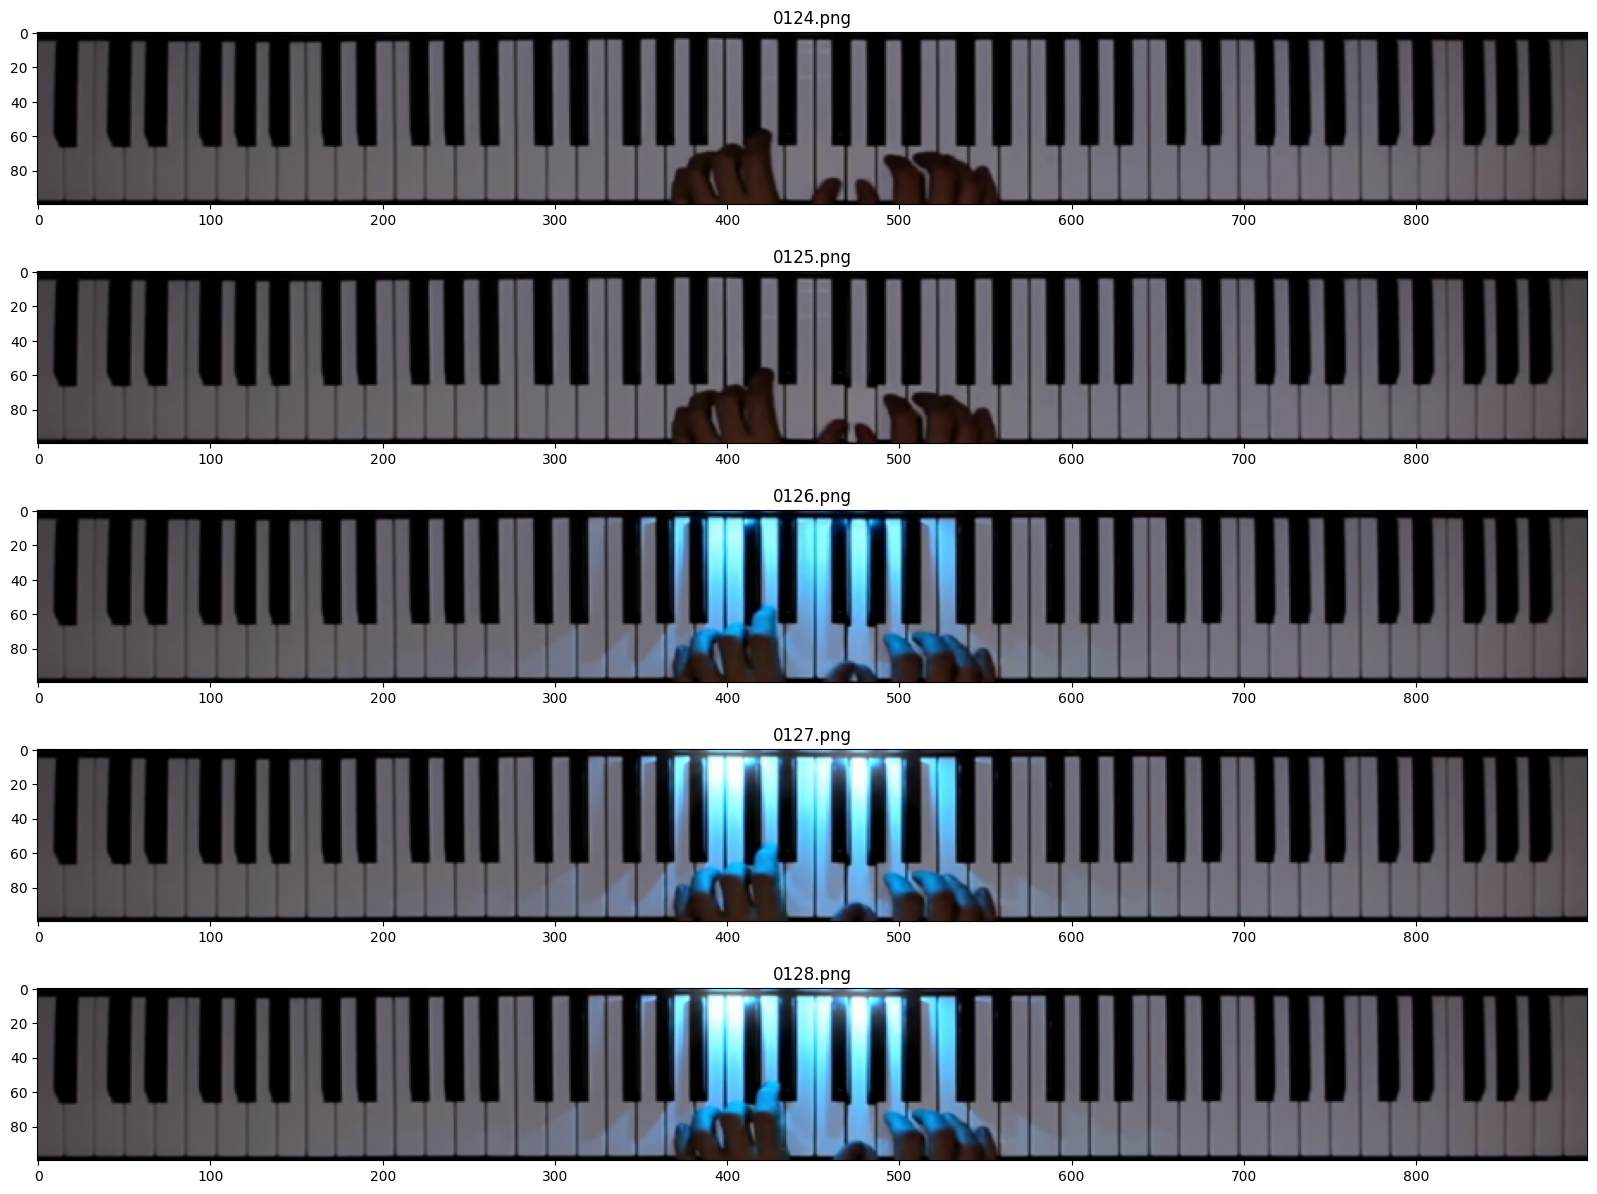

In [2582]:
show_5_images(image_onset_start)

In [2583]:
# bpm 120, ticks per beat 96, 초당 192 tick
# time을 192로 나누면 초로 바뀜
# pedal time도 포함
# fps 25, 

test_midi = MidiFile(f"./data/rousseau/midi_gt_rename/audio_{data_id}.0.midi")

In [2584]:
time_sum = 0
last_note_idx = 0
for i, msg in enumerate(test_midi.tracks[0][::-1]):
    if msg.type == "note_on" or msg.type == "note_off":
        last_note_idx = i
        break

for i, msg in enumerate(test_midi.tracks[0]):
    if msg.type == "control_change":
        msg.time = 0
    elif msg.type == "note_on" or msg.type == "note_off":
        msg.time = 0
        break
        
for msg in test_midi.tracks[0]:
    time_sum += msg.time
    msg.time = time_sum

In [2585]:
# for msg in test_midi.tracks[0]:
#     print(msg, msg.time / 192)

In [2586]:
note_list = []
for msg in test_midi.tracks[0][:-last_note_idx]:
    if msg.type == "note_on":
        note_list.append({"note": msg.note-21, "onset": round(msg.time / 192 * 25)+1, "offset": None})
    elif msg.type == "note_off":
        for note in note_list:
            if msg.note-21 == note["note"] and note["offset"] == None:
                note["offset"] = round(msg.time / 192 * 25)+1

for note in note_list:
    assert note['offset'] is not None

In [2587]:
last_frame = sorted(note_list, key=lambda x: x['offset'])[-1]['offset']

In [2588]:
note_dict = {}

note_dict[1] = np.zeros(88)
note_dict[2] = np.zeros(88)
for i in range(last_frame):
    note_dict[i+3] = np.zeros(88)
note_dict[last_frame+3] = np.zeros(88)
note_dict[last_frame+4] = np.zeros(88)

for note in note_list:
    for i in range(note['onset'], note['offset']+1):
        note_dict[i+2][note['note']] = 1

In [2589]:
image_last_frame = last_frame + image_onset_start - 1

In [2590]:
image_onset_start

126

In [2591]:
image_last_frame

4566

In [2592]:
img_name = images[idx].split("/")[-1]
for enum_i, i in enumerate(tqdm(range(image_onset_start-2, image_last_frame+3))):
    original_file_path = os.path.join(images[idx], f"{str(i).zfill(4)}.png")
    os.makedirs(os.path.join("./data/rousseau/images_align/testing", img_name), exist_ok=True)
    target_file_path = os.path.join("./data/rousseau/images_align/testing", img_name, f"{str(enum_i+1).zfill(4)}.png")
    copyfile(original_file_path, target_file_path)
    # os.system(f"cp '{original_file_path}' '{target_file_path}'")

100% 4445/4445 [00:00<00:00, 7917.30it/s]


In [2593]:
with open(os.path.join("./data/rousseau/labels_align/testing/", img_name + ".pkl"), "wb") as f:
    pickle.dump(note_dict, f)

----------

In [2594]:
test_label = np.load(os.path.join("./data/rousseau/labels_align/testing/", img_name + ".pkl"), allow_pickle=True)
test_image_path = os.path.join("./data/rousseau/images_align/testing/", img_name)

In [2595]:
test_label_np = np.stack(list(test_label.values()))

In [2596]:
test_images_list = sorted(os.listdir(test_image_path), key=lambda x: int(x.split(".")[0]))

In [2597]:
def show_5_images_test(image_idx_mid):
    assert image_idx_mid >= 1
    plt.figure(figsize=(20, 15))
    plt.axis("off")
    plt.subplot(5, 1, 1)
    plt.title(img_list[image_idx_mid-3])
    plt.imshow(Image.open(os.path.join(test_image_path, test_images_list[image_idx_mid-3])))
    plt.subplot(5, 1, 2)
    plt.title(img_list[image_idx_mid-2])
    plt.imshow(Image.open(os.path.join(test_image_path, test_images_list[image_idx_mid-2])))
    plt.subplot(5, 1, 3)
    plt.title(img_list[image_idx_mid-1])
    plt.imshow(Image.open(os.path.join(test_image_path, test_images_list[image_idx_mid-1]))) # mid
    plt.subplot(5, 1, 4)
    plt.title(img_list[image_idx_mid])
    plt.imshow(Image.open(os.path.join(test_image_path, test_images_list[image_idx_mid])))
    plt.subplot(5, 1, 5)
    plt.title(img_list[image_idx_mid+1])
    plt.imshow(Image.open(os.path.join(test_image_path, test_images_list[image_idx_mid+1])))

In [2598]:
test_label_last_idx = test_label_np.shape[0]-3

In [2599]:
assert intkey_to_str(np.where(test_label_np[1]>0)[0]) == []
assert intkey_to_str(np.where(test_label_np[test_label_last_idx+1]>0)[0]) == []
assert len(test_label) == len(os.listdir(test_image_path))

In [2600]:
intkey_to_str(np.where(test_label_np[2]>0)[0])

['C5', 'G5']

/tmp/ipykernel_30728/476807092.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 1, 1)


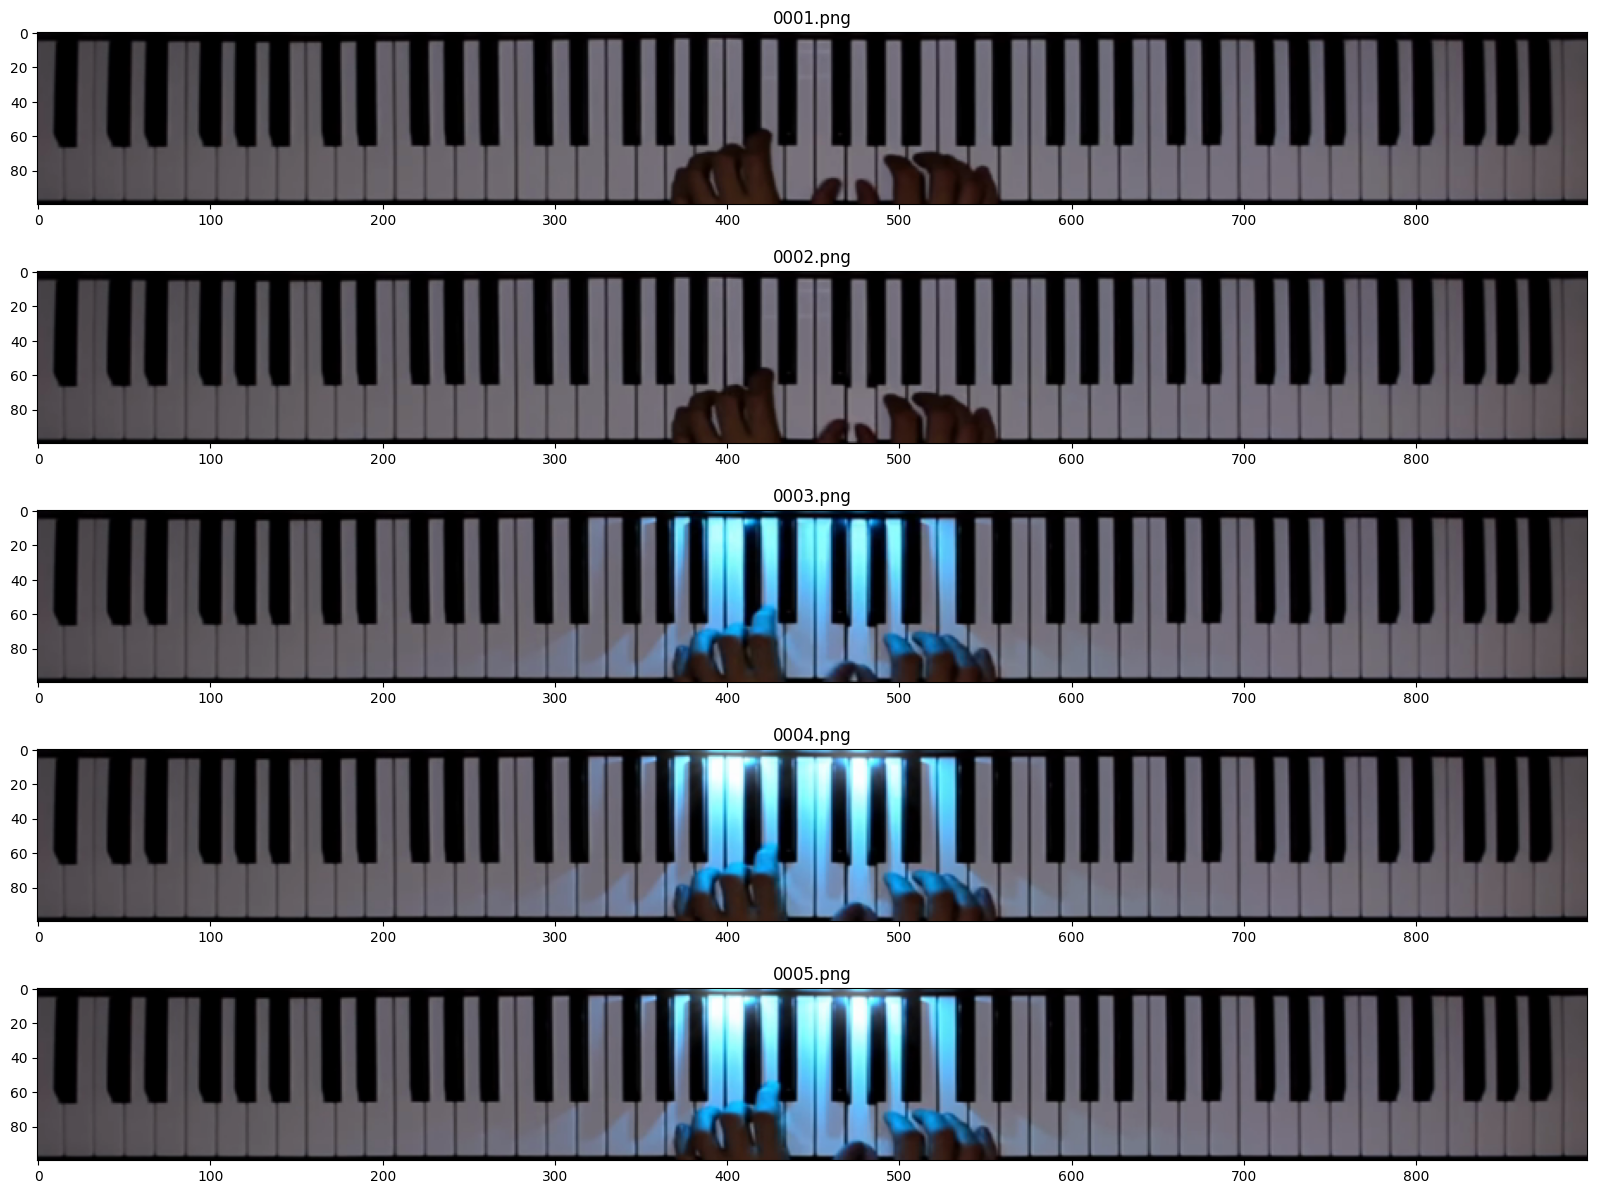

In [2601]:
show_5_images_test(3)

In [2602]:
intkey_to_str(np.where(test_label_np[test_label_last_idx]>0)[0])

['G5', 'G6']

/tmp/ipykernel_30728/476807092.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 1, 1)


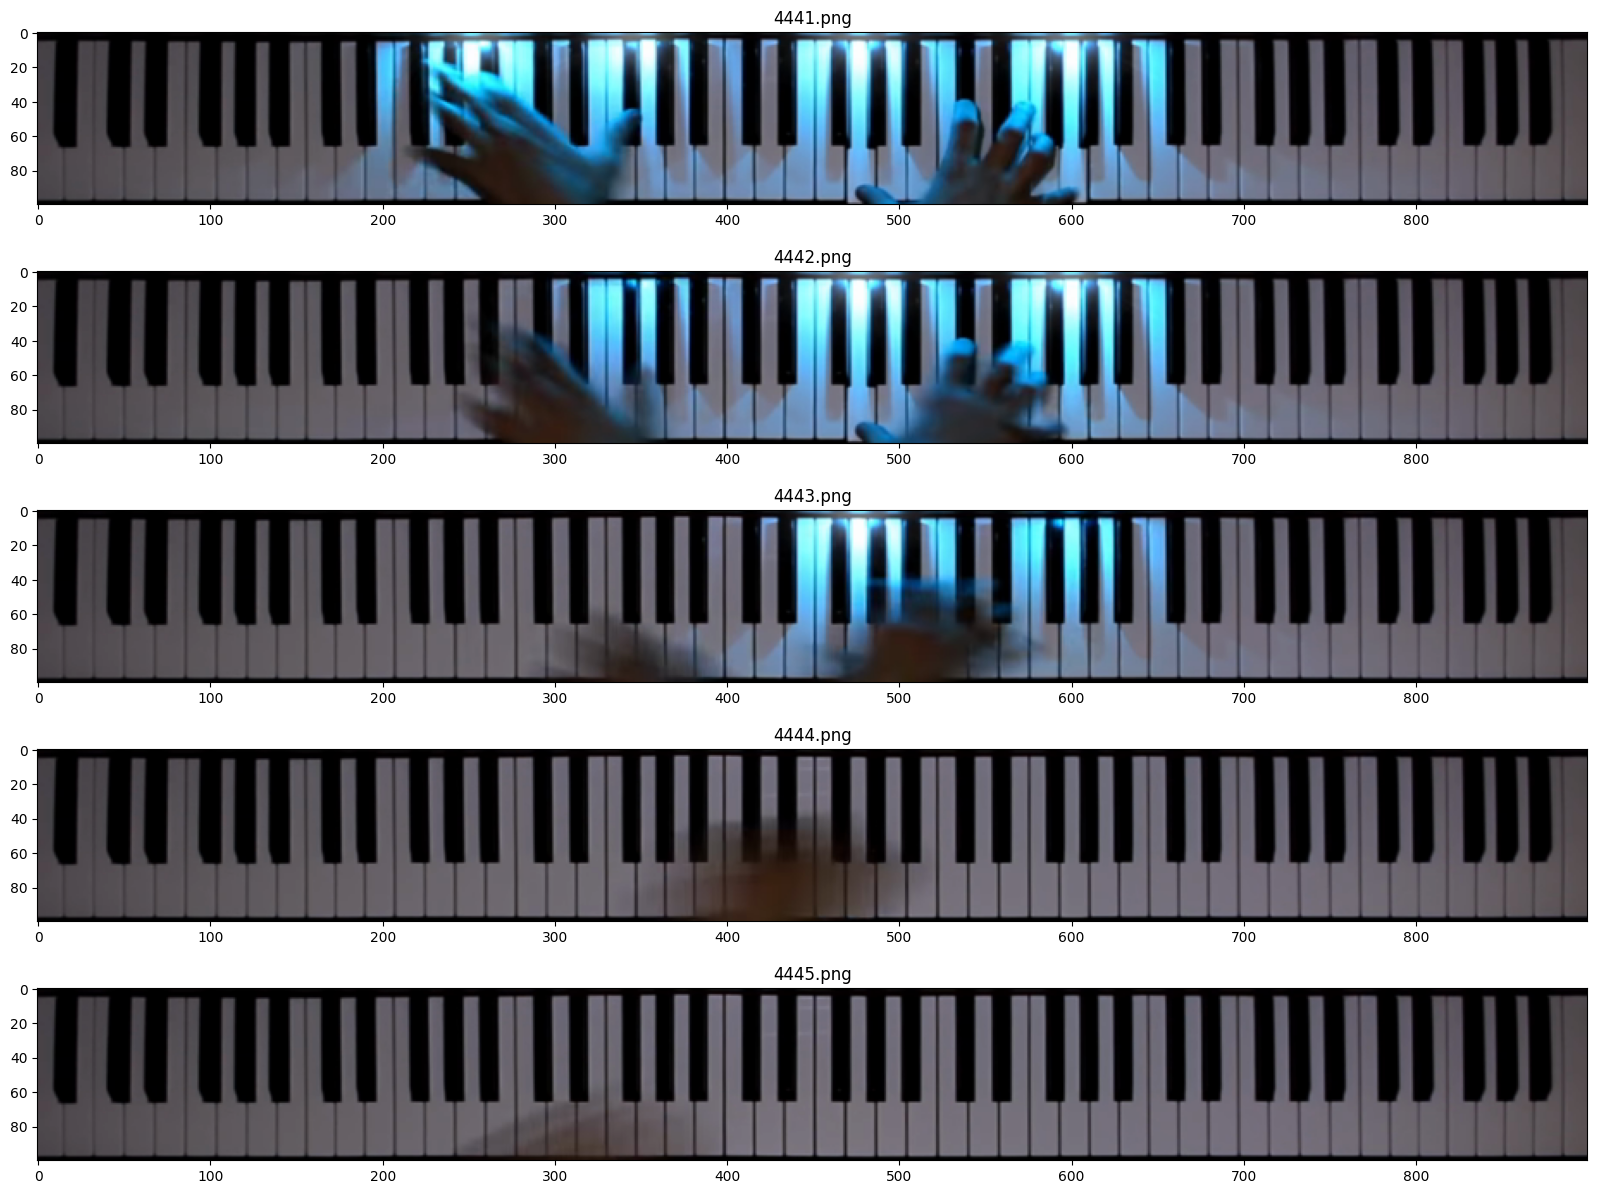

In [2603]:
show_5_images_test(test_label_last_idx+1)

In [2626]:
for img_paths in glob("./data/rousseau/labels_align/testing/*"):
    original_path = img_paths
    new_path = img_paths[:-23] + ".pkl"
    os.rename(original_path, new_path)